In [71]:
from model import *
from sensors2graph import *
from torch_geometric_temporal.signal import temporal_signal_split
from sklearn.preprocessing import StandardScaler
from load_data import *
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split, DynamicGraphTemporalSignal, StaticGraphTemporalSignal

In [ ]:
# Distancd Network
dist_df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data/sensor_graph/distances_kr_city_adj_mx.csv', encoding='cp949', index_col=0)
# base dataframe construct
base_df = pd.DataFrame(0, index=dist_df.index, columns=dist_df.columns)

for city in dist_df.columns:
    # 오름차순 정렬
    col_ = dist_df[[city]].sort_values(by=city, ascending=True)
    # 제일 작은 3개만 연결. symmetric 하지 않아도 networkx에서 graph를 만들 수 있음.
    base_df += (base_df + col_.iloc[1:4]).fillna(0)
    # print(base_df)

base_df += np.eye(len(base_df),len(base_df))

In [6]:
df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_7_city_mean.csv', index_col=0, encoding='cp949')
# df = df.iloc[:630] # 12월 까지만 해보자

############################
## Hyperparameter Setting ##
############################
n_his = 5
save_path = 'stgcnwavemodel.pt'
control_str = 'TSNT'#TNTST' #'TSNT'
num_layers = len(control_str)
n_pred = 1
n_route = num_nodes
blocks = [1, 64, 128, 128, 32, 128]
drop_prob = 0
batch_size = 16
epochs = 30
lr = 0.001
device = torch.device("cpu")

### 컬럼을 숫자로 바꿔줌 ###
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region

num_samples, num_nodes = df.shape

# 시계열 데이터이기 때문에 랜덤 샘플링 하지 않음 훈련 데이터 세트는 과거, 검증 데이터 세트는 항상 약간 뒤의 미래
# W = adj_mx
len_train = round(num_samples * 0.8)
len_val = round(num_samples * 0.15)
len_test = 14
train = df[: len_train]
val = df[len_train: len_train + len_val]
test = df[len_train + len_val:len_train + len_val + len_test]

scaler = StandardScaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

# tensor data로 변환
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

# DataLoader 생성
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=1)

In [133]:
class CovidDatasetLoader(object):
    """
    시발ㅈ같네
    """

    def __init__(self, df, base_df):
        # self._read_web_data()
        self.df = df
        self.base_df = base_df

    def _get_edges(self):
        region_dict = {}
        for i, region in enumerate(base_df.columns):
            region_dict[region] = i

        from_list = []
        to_list = []
        for col in self.base_df.columns:

            for idx in self.base_df[[col]][self.base_df > 0].dropna().index:

                from_list.append(region_dict[col])
                to_list.append(region_dict[idx])

        self.edge_index = np.array([from_list, to_list])

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self.edge_index.shape[1])

    def _get_targets_and_features(self):
        stacked_target = self.df.values
        standardized_target = (stacked_target - np.mean(stacked_target, axis=0)) / (
            np.std(stacked_target, axis=0) + 10 ** -10
        )
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        return np.mean(stacked_target, axis=0), np.std(stacked_target, axis=0)

    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self.edge_index, self._edge_weights, self.features, self.targets
        )
        return dataset

In [134]:
loader = CovidDatasetLoader(df, base_df)
dataset = loader.get_dataset(lags=4)
mean, std = loader._get_targets_and_features()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.98)
train_dataset, val_dataset = temporal_signal_split(train_dataset, train_ratio=0.8)

In [135]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN, MPNNLSTM
from tqdm import tqdm

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        # self.recurrent = MPNNLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
    

############ Train Part ############
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.MSELoss()
model.train()
save_path = 'temporal_signal_test.pt'
min_val_loss = np.inf
for epoch in tqdm(range(200)):
    cost = 0
    l_sum, n = 0.0, 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
        l = loss(snapshot.y, y_hat)
        l_sum += l.item() * snapshot.y.shape[0]
        n += snapshot.y.shape[0]
    cost = cost / (time+1)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    model.eval()
    cost = 0
    for time, snapshot in enumerate(val_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        val_loss = loss(snapshot.y, y_hat)
        
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(min_val_loss, save_path)
        print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)
    model.train()

########## TEST PART ############
best_model = RecurrentGCN(node_features = 4)
best_model.load_state_dict(torch.load(save_path))

model.eval()
cost = 0
ground_truth = []
pred = []
with torch.no_grad():
    # mae, mape, mse = [[] for i in range(shape)], [[] for i in range(shape)], [[] for i in range(shape)]
    mae_t, mape_t, mse_t = [], [], []
    cum_pred = torch.tensor([])
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        
        gt = snapshot.y.detach().numpy() * (std + 10 ** -10)+ mean
        pr = (y_hat.detach().numpy().T * (std + 10 ** -10) + mean)[0]
        
        d = np.abs(gt-pr)
        
        mae_t += d.tolist()
        mape_t += (d / snapshot.y).tolist()
        mse_t += (d ** 2).tolist()
        # cost = cost + torch.mean((y_hat-snapshot.y)**2)
        
        ground_truth.append(gt)
        pred.append(pr)
        
    MAE_total = np.array(mae_t).mean()
    MAPE_total = np.array(mape_t).mean()
    RMSE_total = np.sqrt(np.array(mse_t).mean())
# cost = cost / (time+1)
# cost = cost.item()
print(f"MAE : {MAE_total:.4f}, MAPE : {MAPE_total:4f}, RMSE : {RMSE_total:4f}")

  0%|          | 0/200 [00:00<?, ?it/s]/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([229, 1])) that is different to the input size (torch.Size([229])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/200 [00:02<06:58,  2.11s/it]

tensor(1.0185, grad_fn=<MseLossBackward0>) temporal_signal_test.pt
epoch 0 , train loss: 0.031013325855883022 , validation loss: tensor(1.0185, grad_fn=<MseLossBackward0>)


100%|██████████| 200/200 [05:19<00:00,  1.60s/it]

MAE : 460.8691, MAPE : 397.423302, RMSE : 673.974345


/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Legend does not support 'g' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Legend does not supp

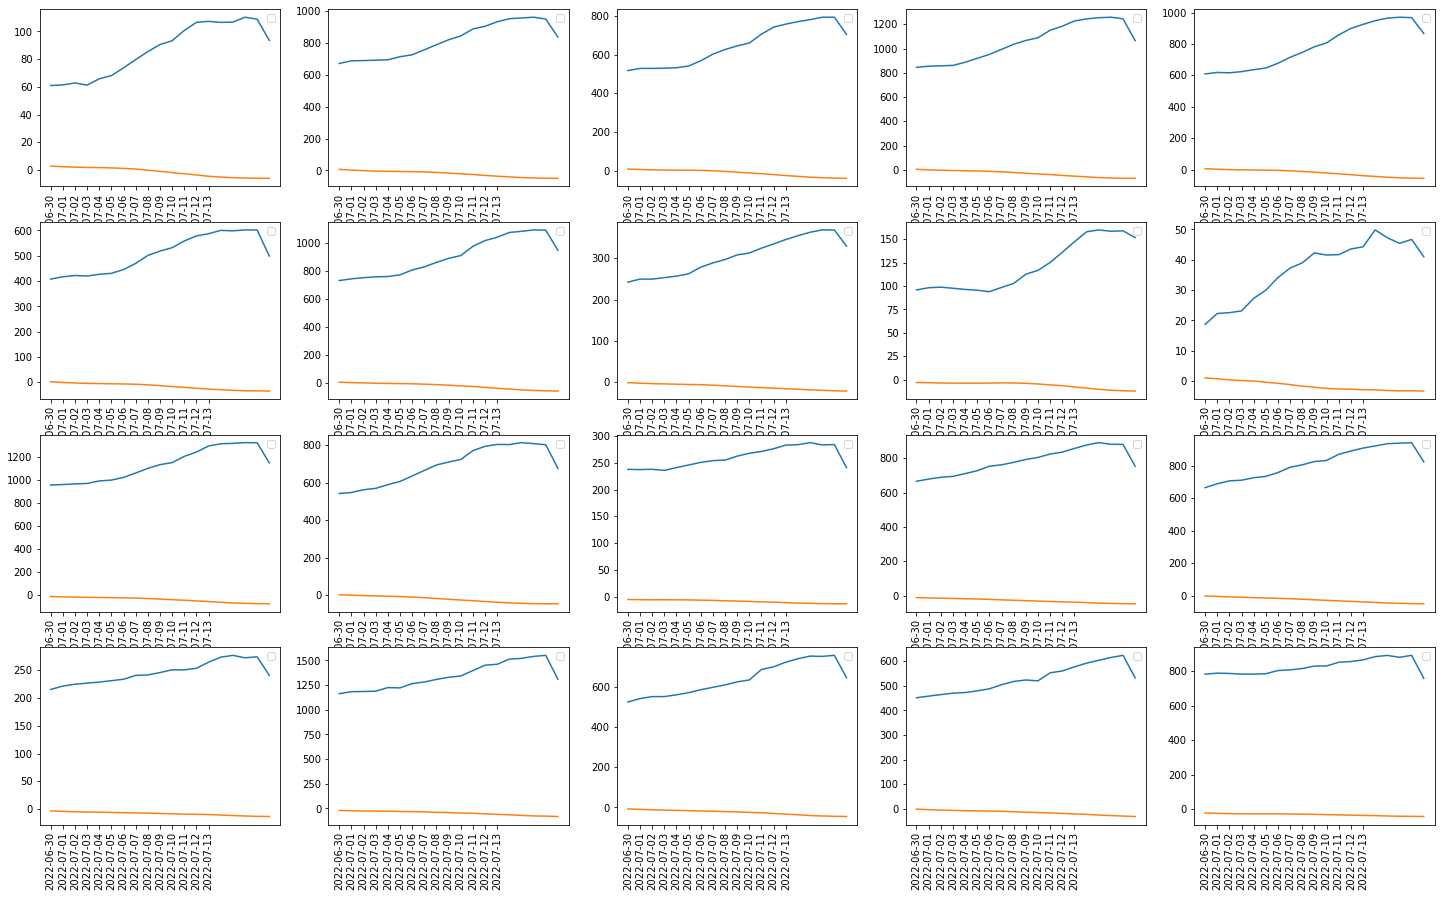

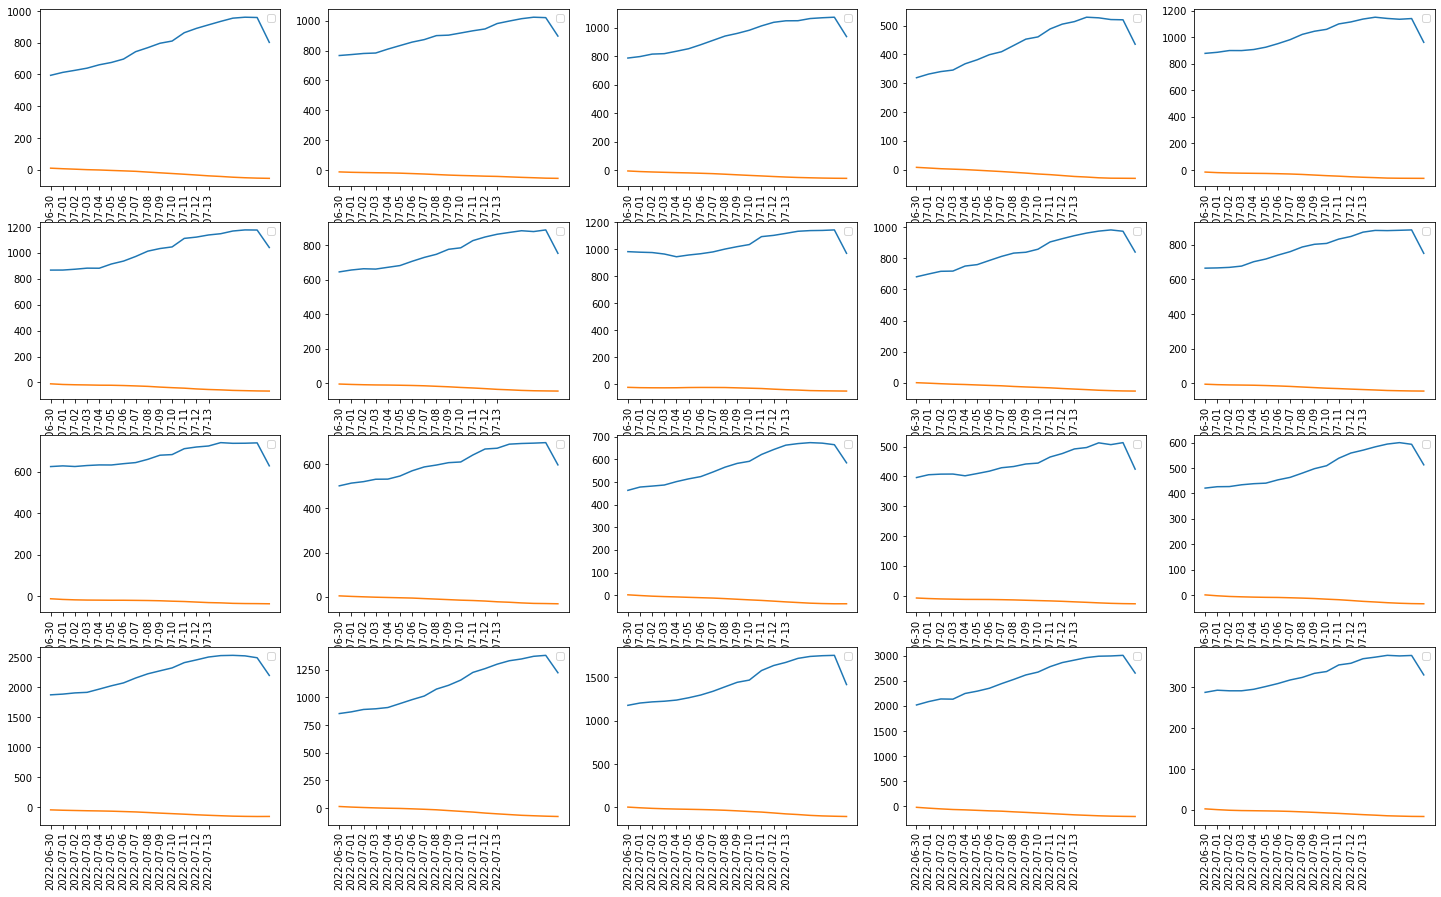

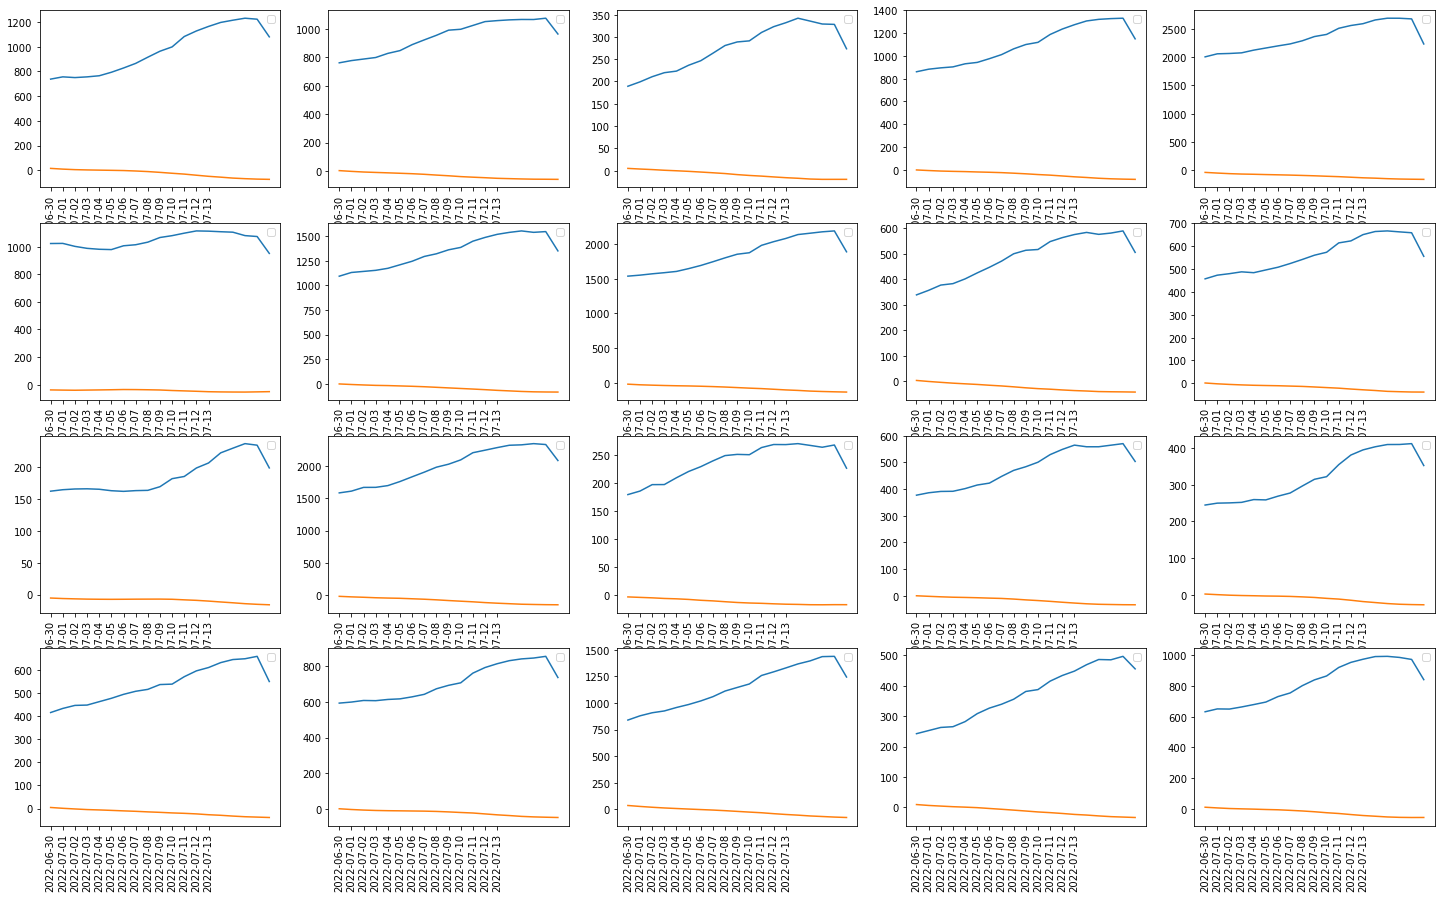

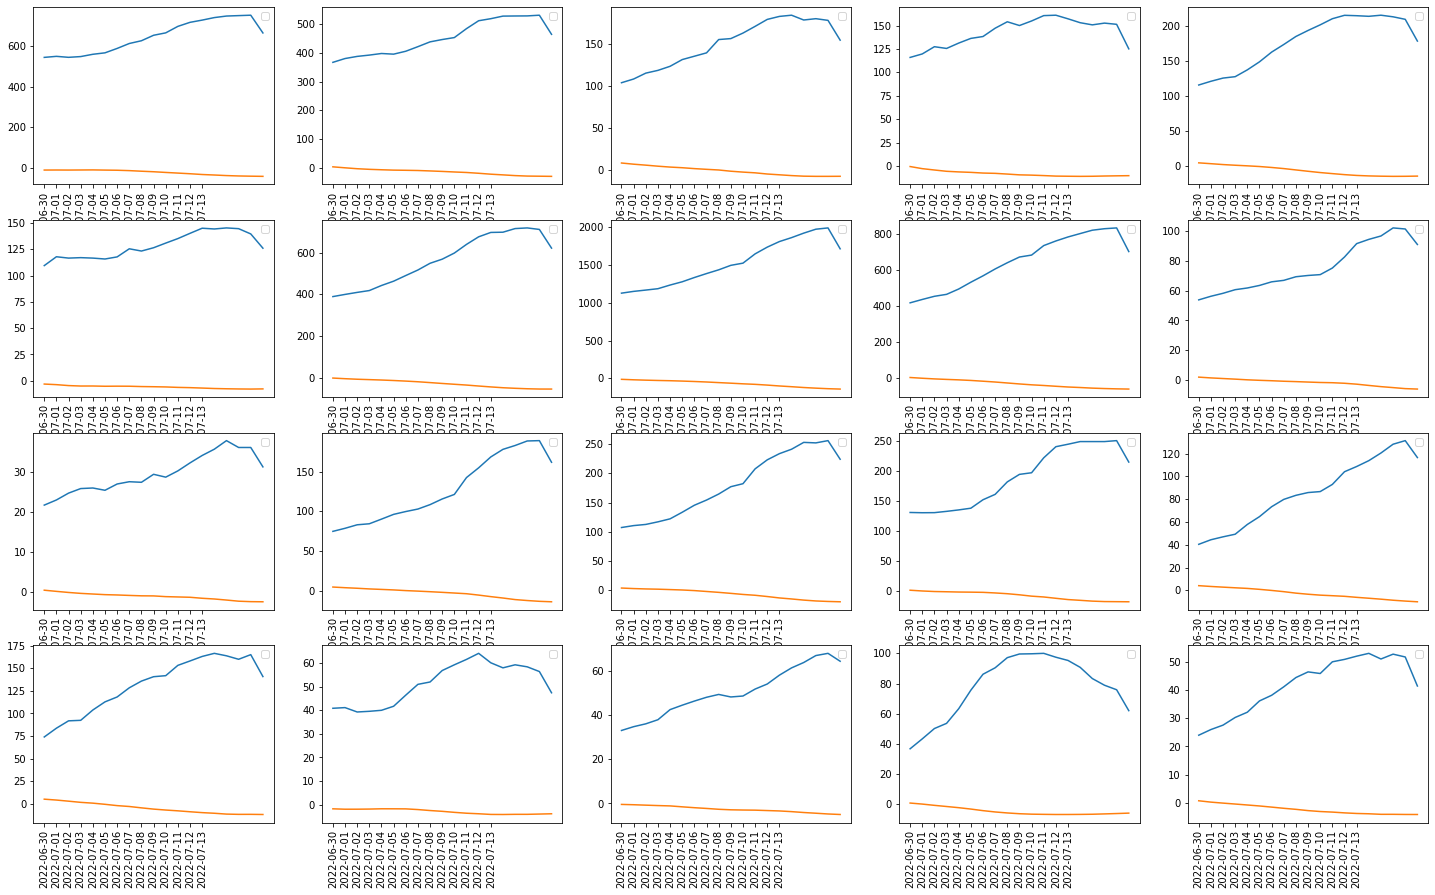

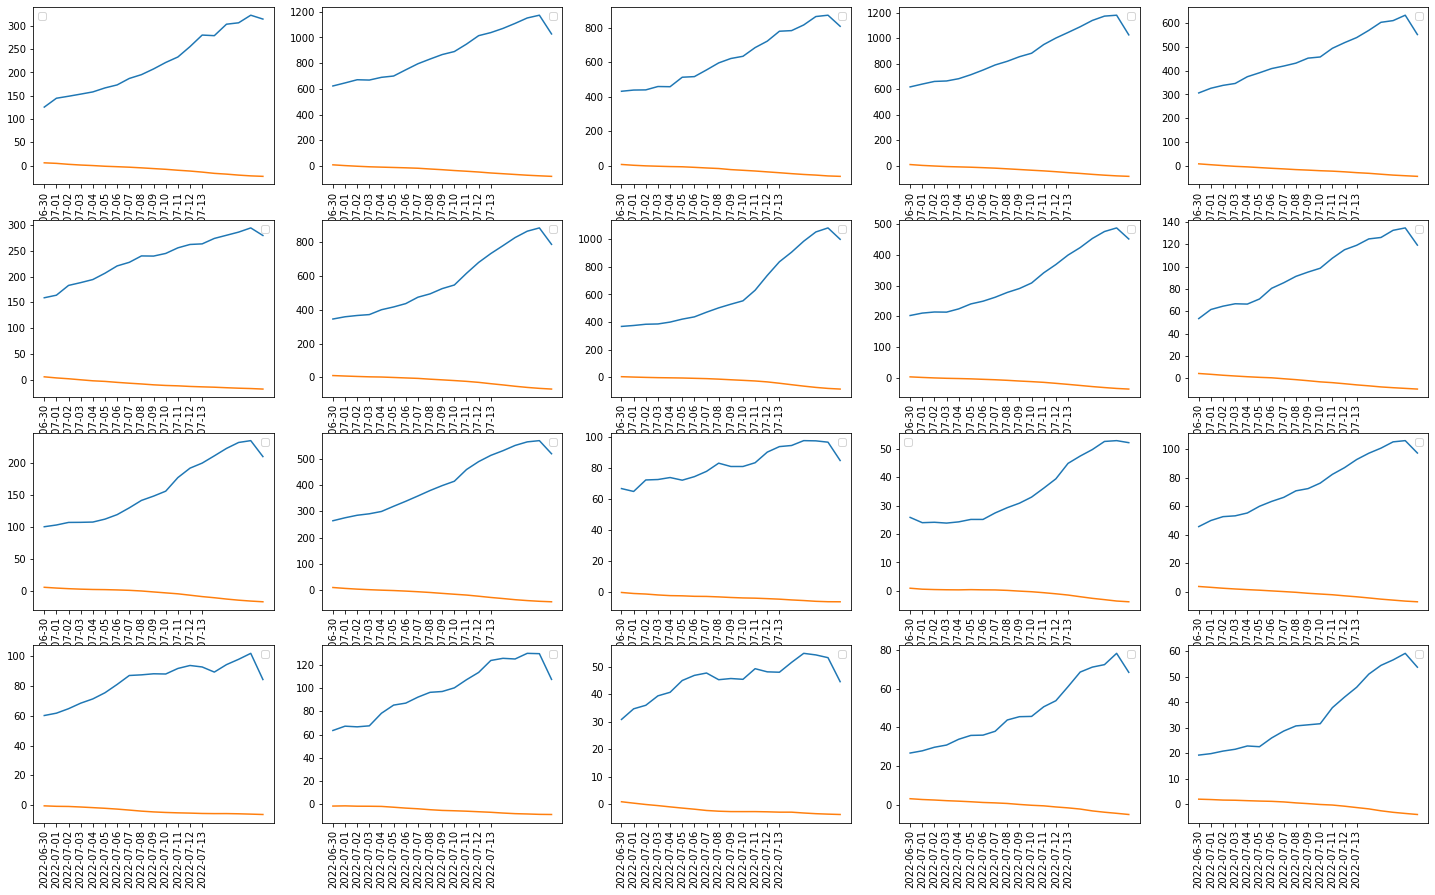

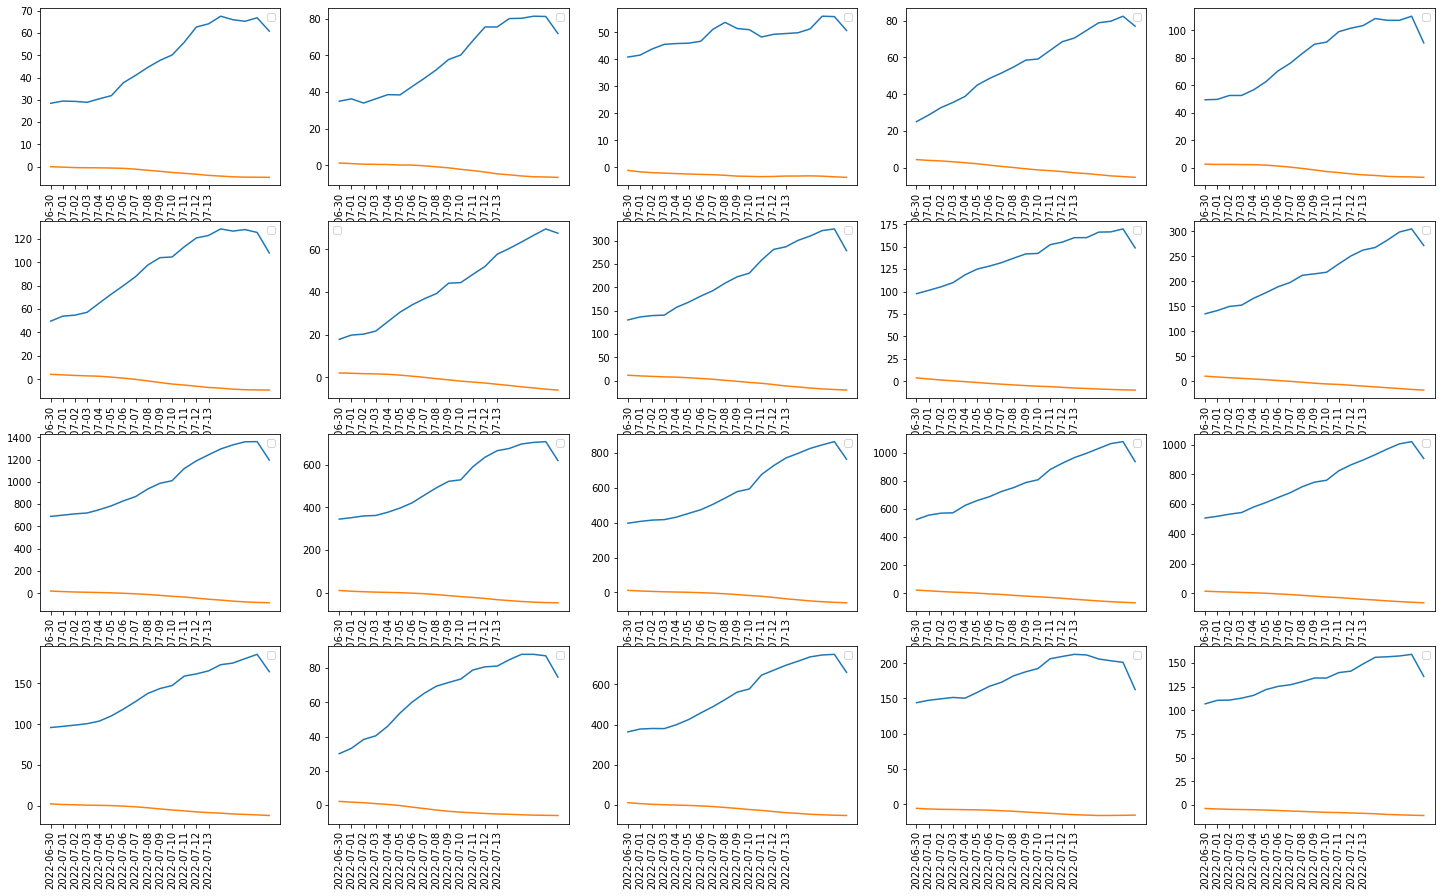

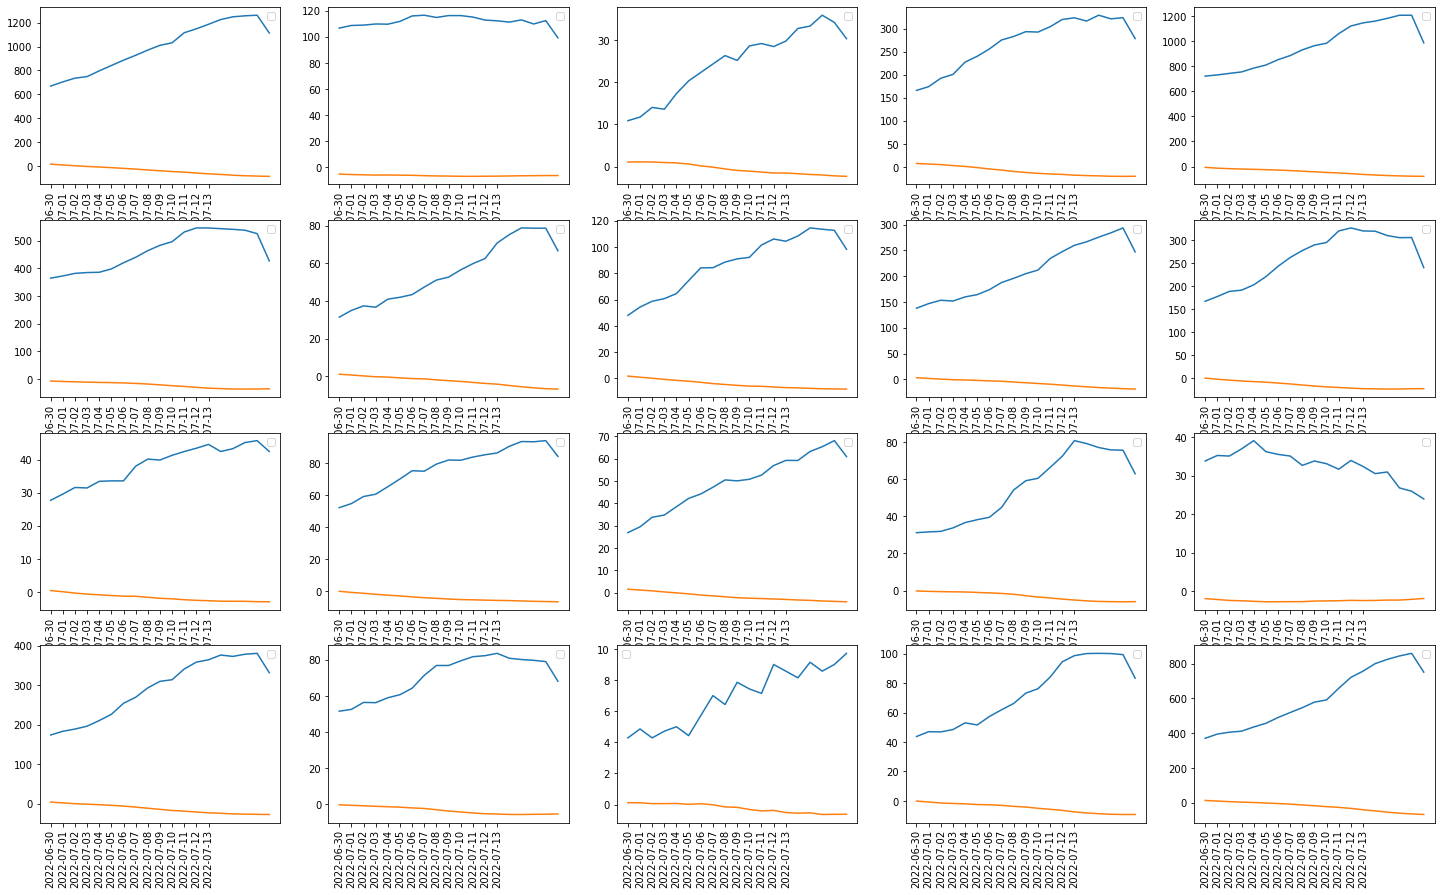

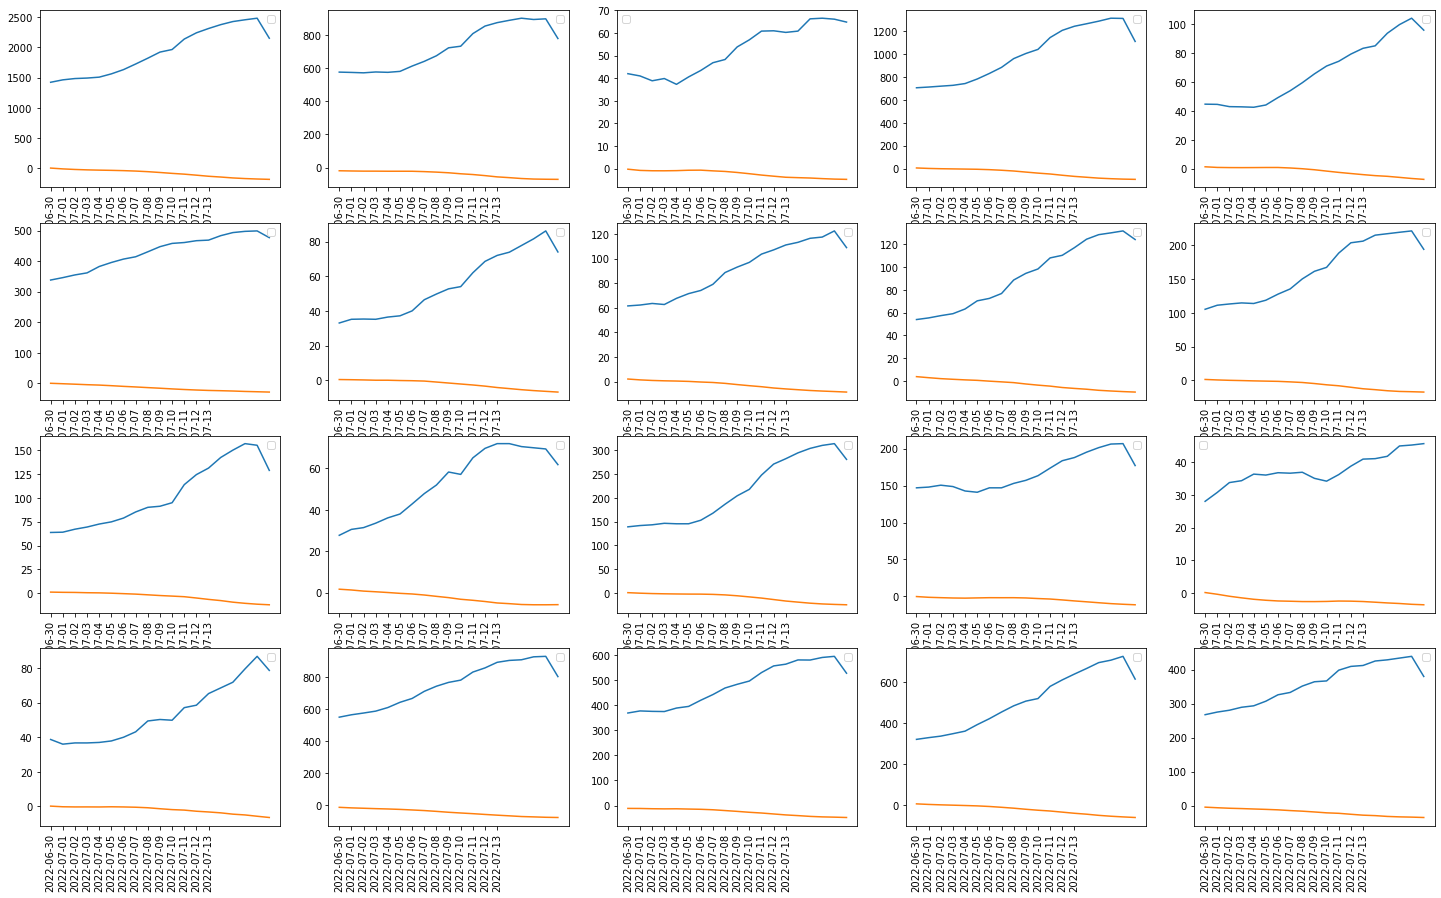

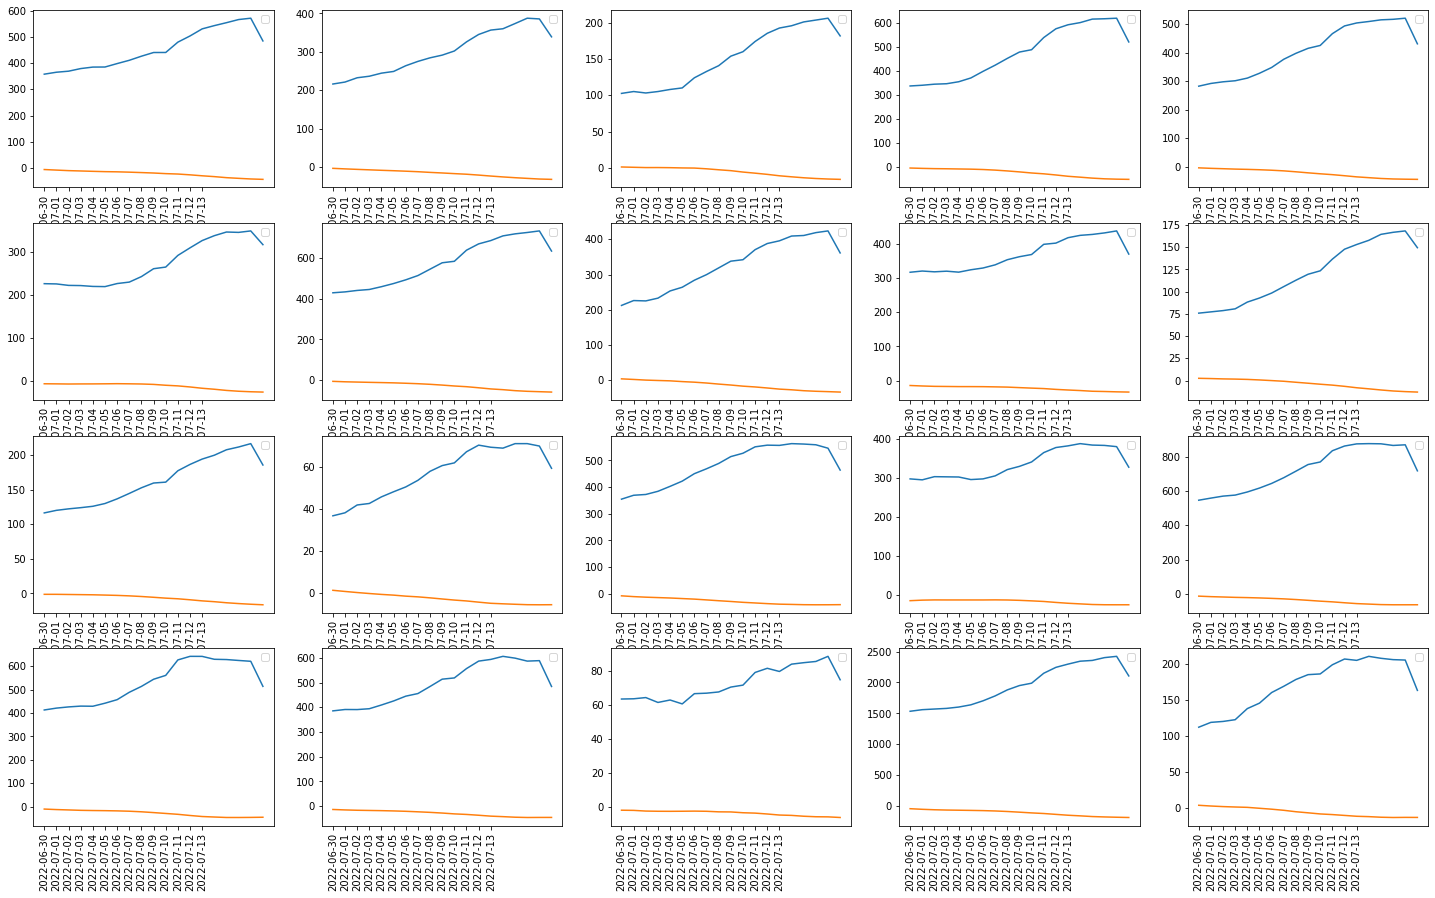

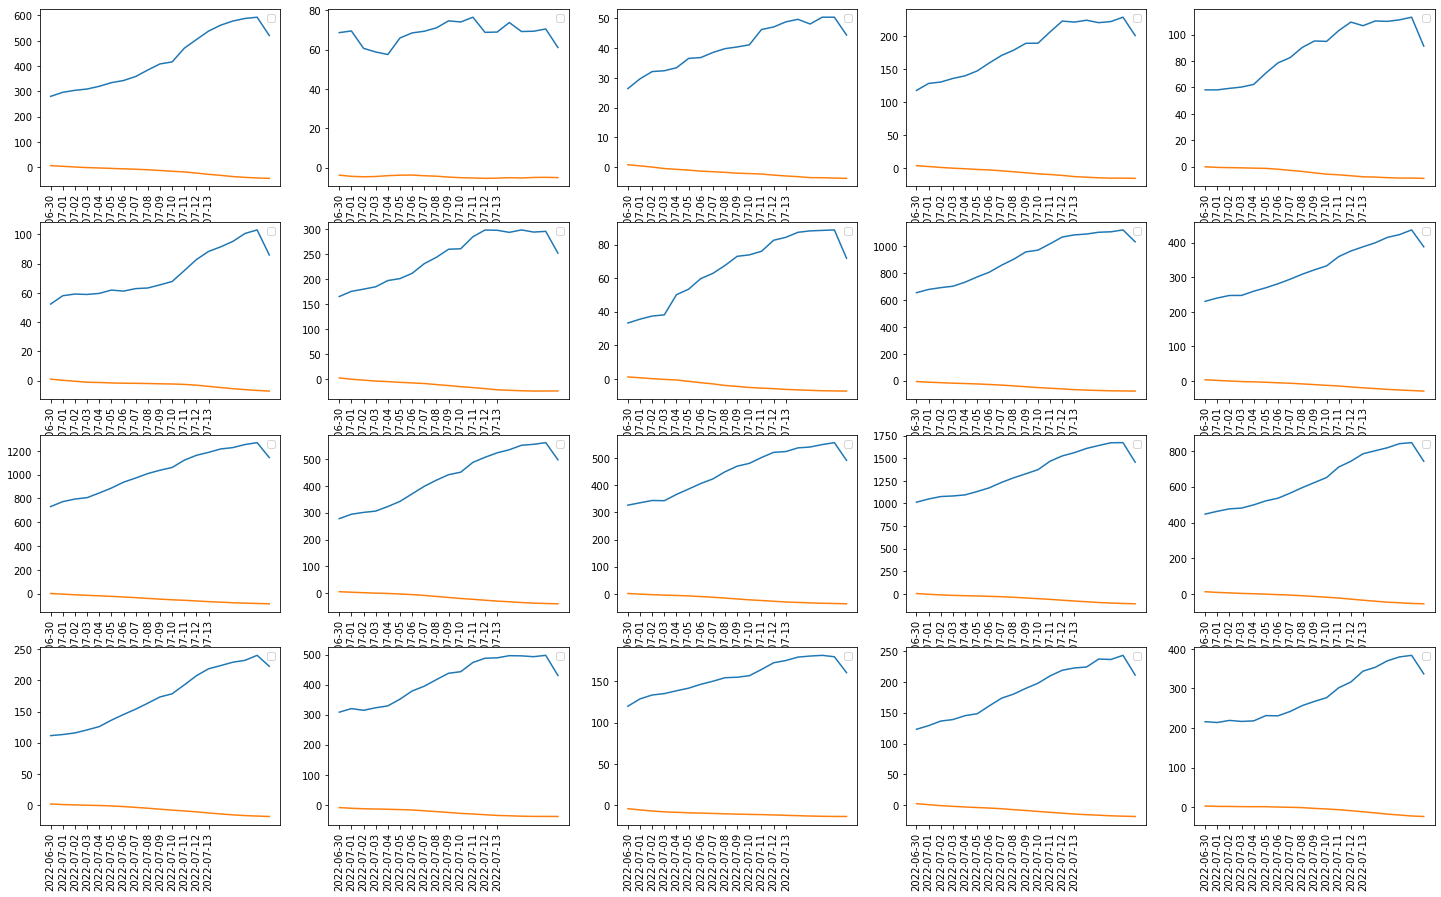

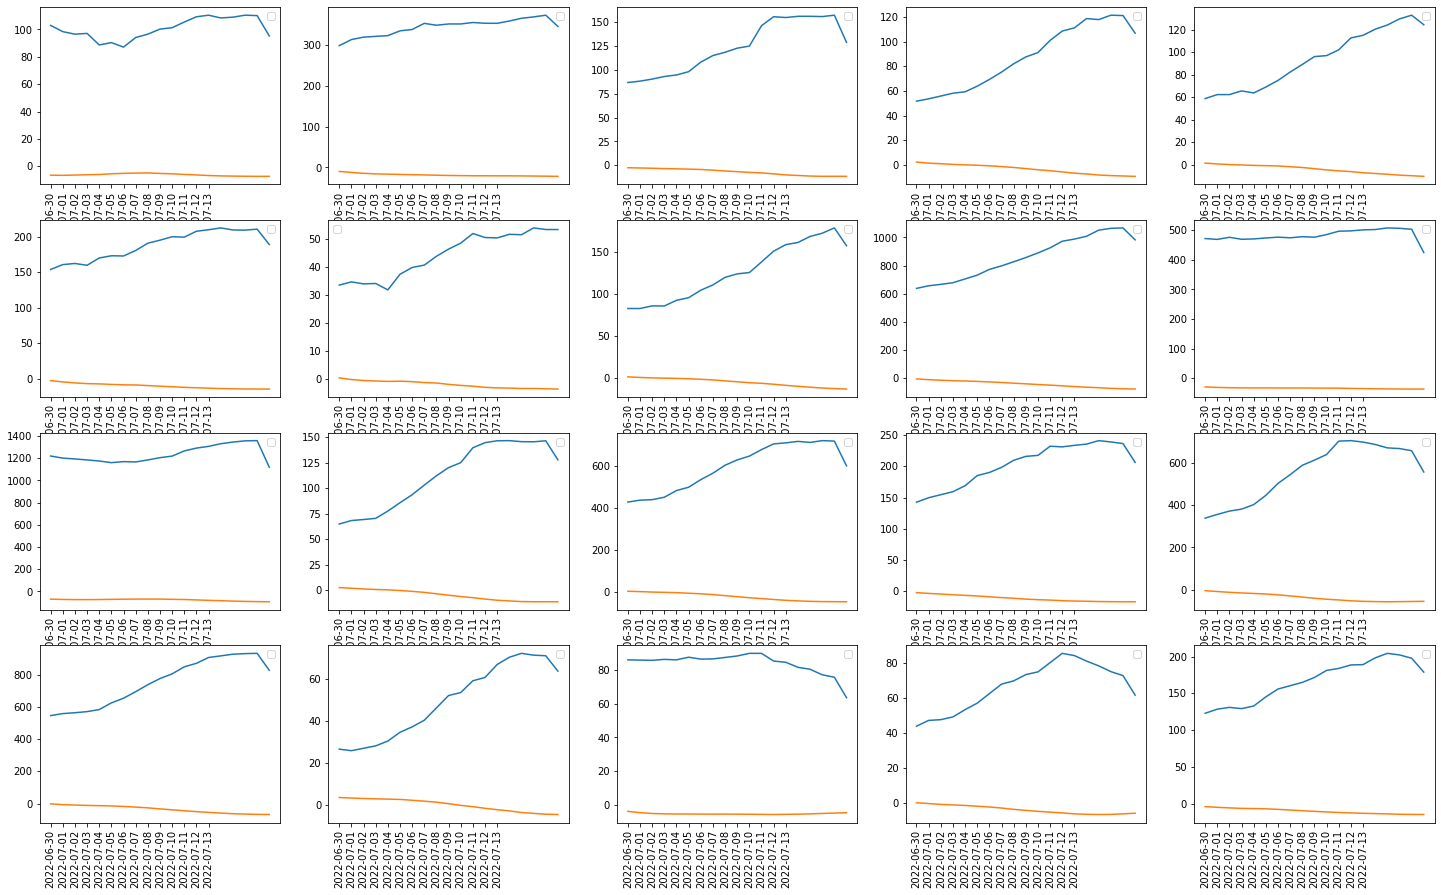

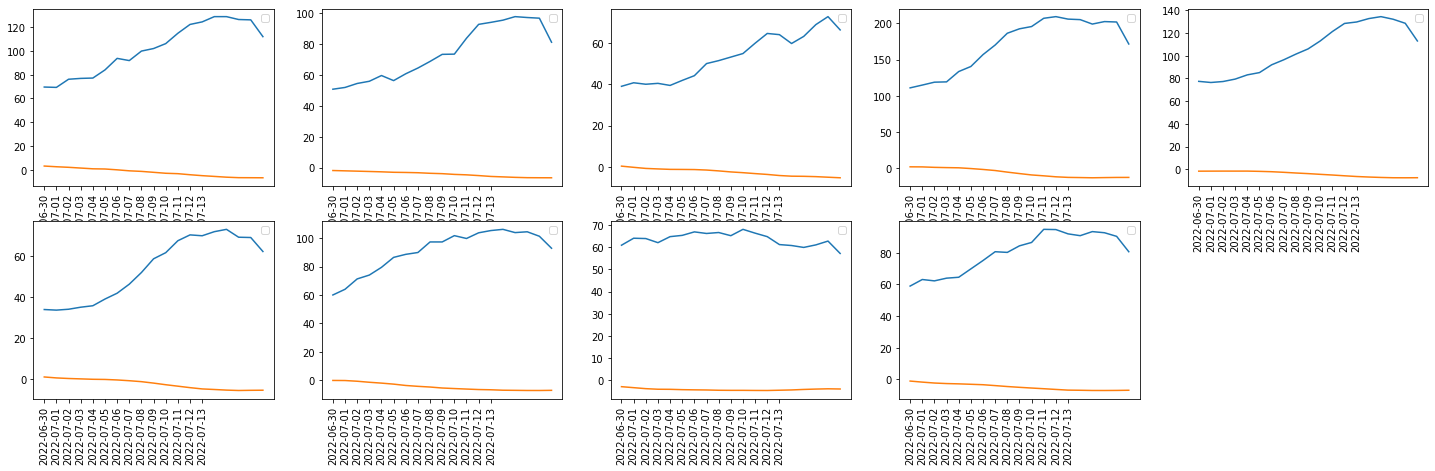

In [136]:
import matplotlib.pyplot as plt
from math import ceil

grth_ = [[] for i in range(len(ground_truth[0]))]
pred_ = [[] for i in range(len(pred[0]))]

for time in range(len(ground_truth)):
    for i in range(len(ground_truth[0])):
        grth_[i].append(ground_truth[time][i])
        pred_[i].append(pred[time][i])


# base figure 정의해주고
for num in range(ceil(len(ground_truth[0])/20)):
    fig = plt.figure(figsize=(25,15), facecolor='white')
    
    # 20개 이상인 지역들을 다른 figure에 plot 하기 위해 범위를 나눠줌
    if num == 0:
        range_ = range(20)
    elif 20*(num+1) > len(ground_truth[0]): # 마지막이 20의 배수보다 작으면
        range_ = range(20*num, len(ground_truth[0]))
    else:
        range_ = range(20*num, 20*(num+1))

    for i in range_: # 17 도시에 대해서 각 도, 66개 수도권 시군구에 대해서 시군구
        if i<20:
            fig.add_subplot(4,5,i+1)
        elif i<40:
            fig.add_subplot(4,5,i-19)
        elif i<60:
            fig.add_subplot(4,5,i-39)
        elif i<80:
            fig.add_subplot(4,5,i-59)
        elif i<100:
            fig.add_subplot(4,5,i-79)
        elif i<120:
            fig.add_subplot(4,5,i-99)
        elif i<140:
            fig.add_subplot(4,5,i-119)
        elif i<160:
            fig.add_subplot(4,5,i-139)
        elif i<180:
            fig.add_subplot(4,5,i-159)
        elif i<200:
            fig.add_subplot(4,5,i-179)
        elif i<220:
            fig.add_subplot(4,5,i-199)
        elif i<240:
            fig.add_subplot(4,5,i-219)
    
        plt.plot(grth_[i])
        plt.plot(pred_[i])
        plt.legend("ground_truth", "predict")
        # plt.title(f"MSE : {cost}") # 각 지역별 MSE가 아닌 전체에 대한 MSE
        
        xlabels = [i for i in list(df.index[len_train + len_val:len_train + len_val + len_test])]
        plt.xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
            